In [14]:
import cv2
import os
import time
import matplotlib.pyplot as plt

# 1.1


In [15]:

cap = cv2.VideoCapture('videoplayback.mp4')
fps = cap.get(cv2.CAP_PROP_FPS)
print(fps)

23.976023976023978


In [16]:
# Save all frames from first 30 seconds of video
frames = []
for i in range(int(fps) * 30):
    ret, frame = cap.read()
    frames.append(frame)
cap.release()

In [17]:
# Save frames to a folder
os.makedirs('images', exist_ok=True)  # Create folder if it doesn't exist
for i, frame in enumerate(frames):
    cv2.imwrite(f'images/frame_{i}.jpg', frame)

In [18]:
print(f'Saved {len(frames)} frames')

Saved 690 frames


# 1.2


In [19]:
# haar = cv2.CascadeClassifier(cv2.data.haarcascades +'haarcascade_frontalface_default.xml')
haar = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [20]:
time_to_process_frame = []

os.makedirs('faces', exist_ok=True)  # Create folder if it doesn't exist

for i, frame in enumerate(frames):
    start_time = time.time()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = haar.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10)
    time_to_process_frame.append(time.time() - start_time)
    for x, y, w, h in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        face = frame
        cv2.imwrite(f'faces/face_{i}.jpg', face)
    

The Haar cascade algorithm uses simple rectangular features called Haar-like features. These features resemble edge, line, and diagonal patterns that are common in faces.

To calculate Haar-like features efficiently, it employs the concept of an integral image. An integral image allows the computation of the sum of pixels within any rectangle using only four corner values.
 
`scaleFactor=1.1` specifies the factor by which the image is resized at each scale during the detection process. A value of 1.1 means the image will be shrunk by 10% at each scale.

`minNeighbors=5`  sets the minimum number of neighboring detections required to consider a region a face. A higher value reduces false positives (detecting non-faces as faces) but might miss some smaller faces.

* Larger images with higher resolutions contain more pixels, requiring more computations to scan for potential faces.
* The presence of multiple faces in an image increases processing time, as the algorithm needs to iterate over each potential face candidate. And these faces will be passed down the cascade thus increasing the time. 
* Smaller faces are more challenging to detect, especially at lower resolutions. This can increase processing time as the algorithm needs to scan across a wider range of scales. The `minsize` parameter can be used to limit the minimum face size to detect.
* Smaller sizes of `minsize` increase the search space and hence the processing time.

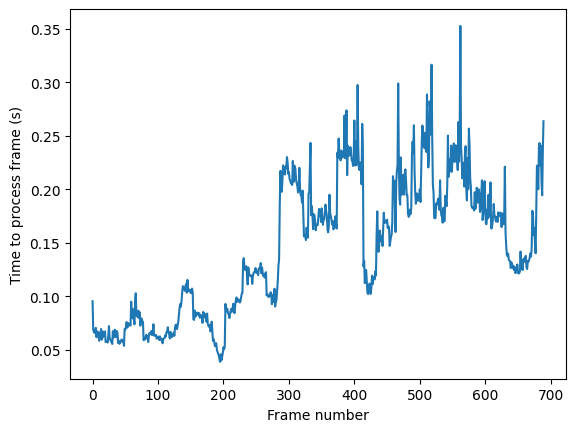

In [21]:
# Plot time to process each frame
plt.plot(time_to_process_frame)
plt.xlabel('Frame number')
plt.ylabel('Time to process frame (s)')
plt.show()

In [22]:
# Average time to process each frame
print(f'Average time to process each frame: {sum(time_to_process_frame) / len(time_to_process_frame):.2f} s')

Average time to process each frame: 0.15 s


# 1.3

In [23]:
# Save the faces from the folder as a video
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.mp4', fourcc, fps, (frame.shape[1], frame.shape[0]))

for i in range(len(frames)):
    frame = cv2.imread(f'faces/face_{i}.jpg')
    out.write(frame)

out.release()


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
[ WARN:0@619.604] global loadsave.cpp:248 findDecoder imread_('faces/face_0.jpg'): can't open/read file: check file path/integrity
[ WARN:0@619.604] global loadsave.cpp:248 findDecoder imread_('faces/face_1.jpg'): can't open/read file: check file path/integrity
[ WARN:0@619.604] global loadsave.cpp:248 findDecoder imread_('faces/face_2.jpg'): can't open/read file: check file path/integrity
[ WARN:0@619.604] global loadsave.cpp:248 findDecoder imread_('faces/face_3.jpg'): can't open/read file: check file path/integrity
[ WARN:0@619.605] global loadsave.cpp:248 findDecoder imread_('faces/face_4.jpg'): can't open/read file: check file path/integrity
[ WARN:0@619.605] global loadsave.cpp:248 findDecoder imread_('faces/face_5.jpg'): can't open/read file: check file path/integrity
[ WARN:0@619.605] global loadsave.cpp:248 findDe

* Since we are using full frontal face detection, we can use the `haarcascade_frontalface_default.xml` file. Thus it is able to detect faces in the frontal view, however, it may not be able to detect faces in other orientations.
* Well-lit images with clear facial features are easier to detect, as the algorithm relies on contrast between facial features and the background.
* Faces need to be relatively large and in focus in the image to be detected accurately. Smaller faces may not be detected, as we are using a lower resolution.

# 1.4


In [24]:
prev_faces=[]
track_counter =0
os.makedirs('faces_track', exist_ok=True)  # Create folder if it doesn't exist


for i, frame in enumerate(frames):
    start_time = time.time()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = haar.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10)
    tracked_faces = []
    for x, y, w, h in faces:
        current_face = (x, y, x+w, y+h)
        matched = False

        if prev_faces:
            prev_frame_faces = prev_faces[-1]

            for prev_face in prev_frame_faces:
                intersection = (min(current_face[2], prev_face[2]) - max(current_face[0], prev_face[0])) * (min(current_face[3], prev_face[3]) - max(current_face[1], prev_face[1]))
                prev_area = (prev_face[2] - prev_face[0]) * (prev_face[3] - prev_face[1])
                current_area = (current_face[2] - current_face[0]) * (current_face[3] - current_face[1])
                overlap = intersection / (prev_area + current_area - intersection)

                if overlap > 0.5:
                    curr_face_list = list(current_face)
                    curr_face_list.append(i)
                    curr_face_list.append(prev_face[-1])
                    current_face = tuple(curr_face_list)
                    tracked_faces.append(current_face)
                    matched = True
                    break
        if not matched:
            curr_face_list = list(current_face)
            curr_face_list.append(i)
            curr_face_list.append(track_counter)
            current_face = tuple(curr_face_list)
            track_counter += 1
            tracked_faces.append(current_face)

        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        face = frame
        cv2.imwrite(f'faces/face_{i}.jpg', face)
    
    prev_faces.append(tracked_faces)

    # Part 3
    for face in tracked_faces:
        (x, y, x2, y2, f_num, t_id) = face
        cv2.rectangle(frame, (x, y), (x2, y2), (255, 0, 0), 2)
        cv2.putText(frame, f'{t_id}', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

    cv2.imwrite(f'faces_track/face_track_{i}.jpg', frame)



In [25]:
# Number of faces tracked
print(f'Number of faces tracked: {track_counter}')

Number of faces tracked: 46


We observed 46 track ids in first 30 seconds. The Haar cascade classifier may struggle to consistently detect faces across all frames. This can occur due to factors like changing lighting conditions, occlusions, or faces moving in and out of the frame. These breaks in detection necessitate the creation of new track IDs.

In [26]:
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output_tracking.mp4', fourcc, fps, (frame.shape[1], frame.shape[0]))

for i in range(len(frames)):
    frame = cv2.imread(f'faces_track/face_track_{i}.jpg')
    out.write(frame)

out.release()

OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


The same character may be assigned multiple tracks due to discontinuous face detection. This can occur if the classifier fails to detect a face in a frame, leading to the creation of a new track ID when the face reappears in a subsequent frame. eg: 00:08 to 00:10. The same person is assgined 11-13 track ids.

Since not many faces are detected in the video, different faces aren't assigned the same track ID.

Here's the link to the video: [video](https://drive.google.com/file/d/1C93KqJ6-zr19J3Djlz5DJ5BSqWpwkUnY/view?usp=drive_link)